In [1]:
#Root 경로로 이동
%cd ..

#참고사이트 : https://towardsdatascience.com/medical-image-pre-processing-with-python-d07694852606

d:\MyGit\BrainMR_MCI


In [2]:
import dataloader
import pandas as pd
import utils
import numpy as np

In [5]:
config = utils.load_config()

In [6]:
df_dataset = pd.read_csv(config['PATH_DATASET_CSV'])
df_dataset = df_dataset.dropna()
img_dataset = dataloader.load_dataset(df_dataset[:10])

d:\MyGit\BrainMR_MCI\dataloader.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img_dataset = np.array([process_scan(source,path) for source,path in np.array(df_dataset[['source','path']])])


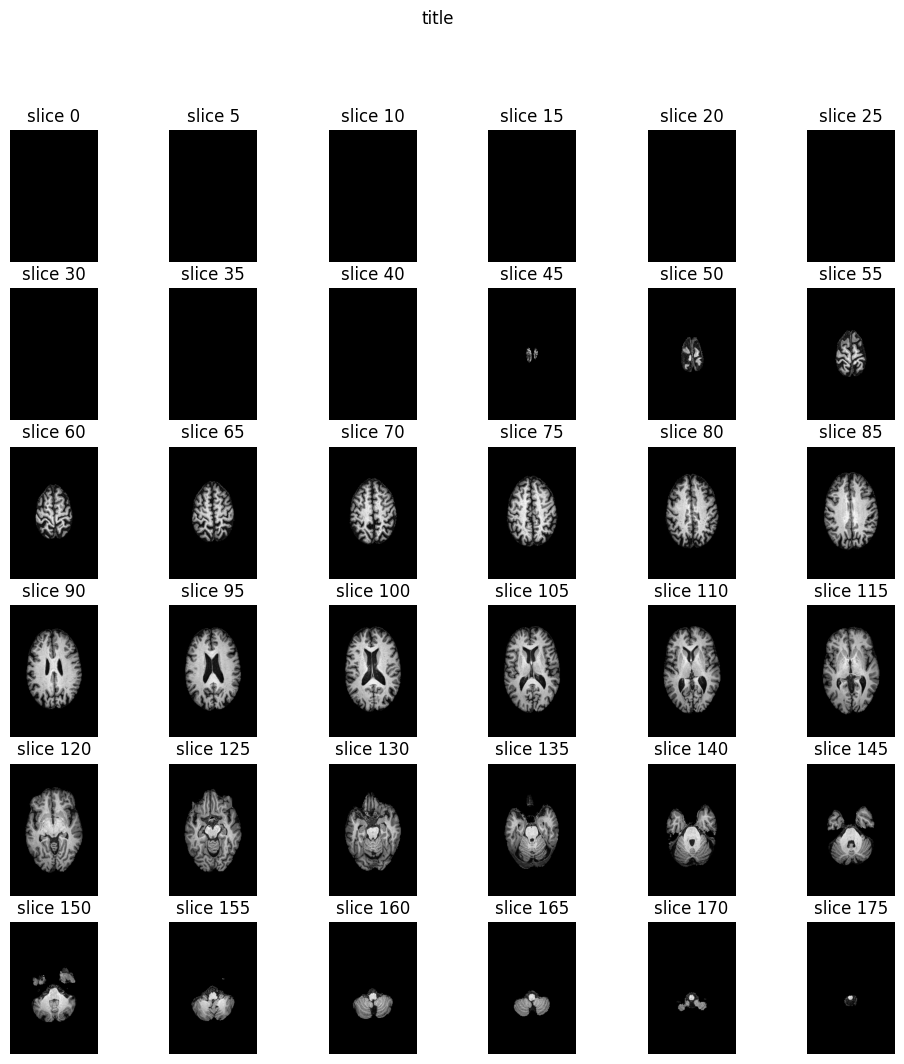

In [7]:
utils.stack_plot(img_dataset[0])

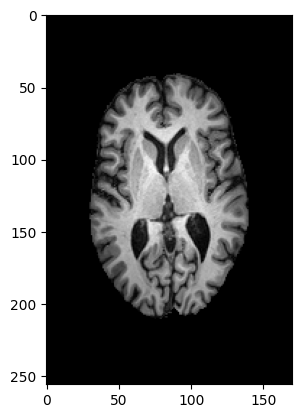

In [9]:
#image crop
sample_image = img_dataset[0][:,:,110]
utils.image_plot(sample_image)

In [12]:
def crop_images(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0
    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1],:]
    
    return croped_image

def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0
    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1]]
    
    return croped_image

def add_pad(image, new_height=256, new_width=256):
    height, width, depth = image.shape

    final_image = np.zeros((new_height, new_width, depth))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width,:] = image
    
    return final_image

(170, 110, 256)
(256, 256, 256)


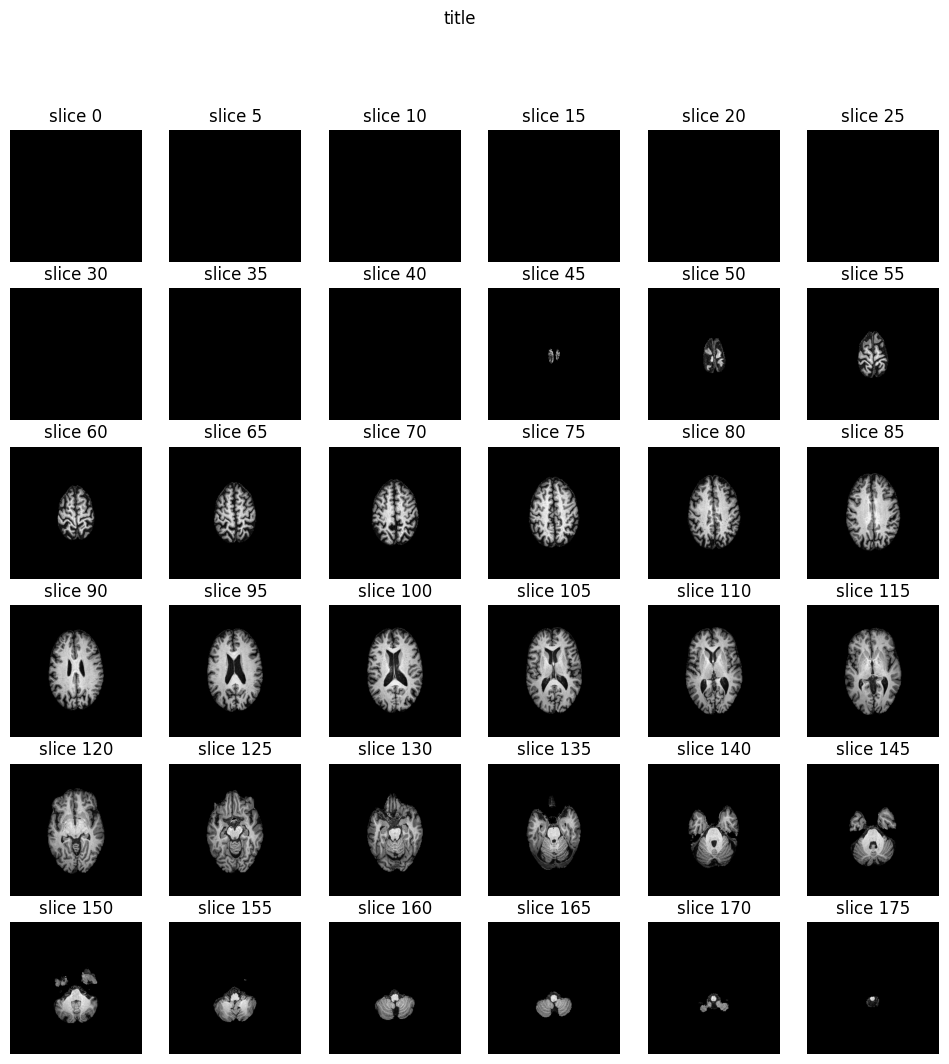

In [14]:
image = img_dataset[0]
image = crop_images(image)
print(image.shape)
image = add_pad(image)
print(image.shape)
utils.stack_plot(image)

55 29
226 139
(256, 170)
(171, 110)


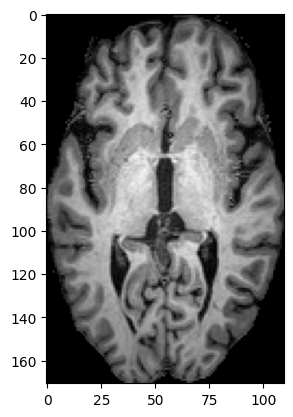

In [8]:
#image crop
sample_image = img_dataset[0][:,:,110]
sample_image_pre = crop_image(sample_image)
print(sample_image.shape)
print(sample_image_pre.shape)
utils.image_plot(sample_image_pre)